# Facial Recognition Model using TensorFlow & Machine Learning

In [9]:
import sys
sys.executable

'C:\\Users\\AparnaChoubey\\anaconda3\\python.exe'

In [3]:
import tensorflow as tf

In [4]:
print(tf.__version__)

1.15.0


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [8]:
print(np.__version__)

1.18.1


In [25]:
base_dir = "train"

# We are trying to minimize the resolution of the images without loosing the 'Features'
# For facial recognition, this seems to be working fine, you can increase or decrease it
IMAGE_SIZE = 224

# Depending upon the total number of images you have set the batch size
# I have 50 images per person (which still won't give very accurate result)
# Hence, I am setting my batch size to 5
# So in 10 epochs/iterations batch size of 5 will be processed and trained
BATCH_SIZE = 5

# We need a data generator which rescales the images
# Pre-processes the images like re-scaling and other required operations for the next steps
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2)

# We separate out data set into Training, Validation & Testing. Mostly you will see Training and Validation.
# We create generators for that, here we have train and validation generator.
# Create a train_generator
train_generator = data_generator.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')

# Create a validation generator
val_generator = data_generator.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation')

# Triggering a training generator for all the batches
for image_batch, label_batch in train_generator:
    break
    
# This will print all classification labels in the console
print(train_generator.class_indices)


Found 98 images belonging to 6 classes.
Found 23 images belonging to 6 classes.
{'Chandler': 0, 'Joey': 1, 'Monica': 2, 'Phoebe': 3, 'Rachel': 4, 'Ross': 5}


In [26]:
# Creating a file which will contain all names in the format of next lines
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

# Writing it out to the file which will be named 'labels.txt'
with open('labels.txt', 'w') as f:
    f.write(labels)


In [27]:
"""
We have to create the base model from the pre-trained CNN
Create the base model from the **MobileNet V2** model developed at Google
and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.
First, pick which intermediate layer of MobileNet V2 will be used for feature extraction. 
A common practice is to use the output of the very last layer before the flatten operation,
The so-called "bottleneck layer". The reasoning here is that the following fully-connected layers 
will be too specialized to the task the network was trained on, and thus the features learned by
These layers won't be very useful for a new task. The bottleneck features, however, retain much generality.
Let's instantiate an MobileNet V2 model pre-loaded with weights trained on ImageNet. 
By specifying the `include_top=False` argument, we load a network that doesn't include the
classification layers at the top, which is ideal for feature extraction.
"""

# Resolution of images (Width , Height, Array of size 3 to accommodate RGB Colors)
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2 Hidden and output layer is in the model The first
# layer does a redundant work of classification of features which is not required to be trained
# (This is also called as bottle neck layer)

# Hence, creating a model with EXCLUDING the top layer
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [28]:
# Feature extraction
# You will freeze the convolution base created from the previous step and use that as a feature extractor
# Add a classifier on top of it and train the top-level classifier.

# We will be tweaking the model with our own classifications
# Hence we don't want our tweaks to affect the layers in the 'base_model'
# Hence we disable their training
base_model.trainable = False

# Add a classification head
# We are going to add more classification 'heads' to our model

# 1 -   We are giving our base model (Top Layer removed, hidden and output layer UN-TRAINABLE)

# 2 -   2D Convolution network (32 nodes, 3 Kernel size, Activation Function)
#       [Remember how Convolutions are formed, with role of kernels]
#       [ Kernels in Convents are Odd numbered]
#       [ Kernels are just a determinant which is multiplied with Image Matrix]
#       [They help in enhancement of features]

# 3 -   We don't need all nodes, 20% of nodes will be dropped out [probability of each "bad" node being dropped is 20%
#       Bad here means the nodes which are not contributing much value to the final output

# 4 -   Convolution and pooling - 2X2 matrix is taken and a pooling is done
#       Pooling is done for data size reduction by taking average

# 5 -   All above are transformation layers, this is the main Dense Layer
#       Dense layer takes input from all prev nodes and gives input to all next nodes.
#       It is very densely connected and hence called the Dense Layer.
#       We are using the Activation function of 'Softmax'
#       There is another popular Activation function called 'Relu'

model = tf.keras.Sequential([
    base_model,  # 1
    tf.keras.layers.Conv2D(32, 3, activation='relu'),  # 2
    tf.keras.layers.Dropout(0.2),  # 3
    tf.keras.layers.GlobalAveragePooling2D(),  # 4
    tf.keras.layers.Dense(6, activation='softmax')  # 5
])

# You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss.
# Since we have added more classification nodes, to our existing model, we need to compile the whole thing
# as a single model, hence we will compile the model now

# 1 - BP optimizer [Adam/Xavier algorithms help in Optimization]
# 2 - Weights are changed depending upon the 'LOSS' ['RMS, 'CROSS-ENTROPY' are some algorithms]
# 3 - On basis of which parameter our loss will be calculated? here we are going for accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(),  # 1
              loss='categorical_crossentropy',  # 2
              metrics=['accuracy'])  # 3

# To see the model summary in a tabular structure
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 2,626,854
Trainable params: 368,870
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
# Printing some statistics
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))


Number of trainable variables = 4


In [31]:
# Train the model
# We will do it in 10 Iterations
epochs = 10

# Fitting / Training the model
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/10
20/20 [==============================] - 23s 1s/step - loss: 0.9591 - acc: 0.6327 - val_loss: 2.2601 - val_acc: 0.4348
Epoch 2/10
20/20 [==============================] - 25s 1s/step - loss: 0.6818 - acc: 0.7755 - val_loss: 1.6715 - val_acc: 0.4783
Epoch 3/10
20/20 [==============================] - 24s 1s/step - loss: 0.7715 - acc: 0.7143 - val_loss: 1.8664 - val_acc: 0.5217
Epoch 4/10
20/20 [==============================] - 23s 1s/step - loss: 0.5450 - acc: 0.8367 - val_loss: 1.8422 - val_acc: 0.5217
Epoch 5/10
20/20 [==============================] - 23s 1s/step - loss: 0.5334 - acc: 0.7959 - val_loss: 1.9019 - val_acc: 0.4348
Epoch 6/10
20/20 [==============================] - 23s 1s/step - loss: 0.4295 - acc: 0.9082 - val_loss: 1.9583 - val_acc: 0.4783
Epoch 7/10
20/20 [==============================] - 23s 1s/step - loss: 0.4489 - acc: 0.8367 - val_loss: 3.2484 - val_acc: 0.3913
Epoch 8/10
20/20 [==============================] - 23s 1s/step - loss: 0.3288 - acc: 0.91

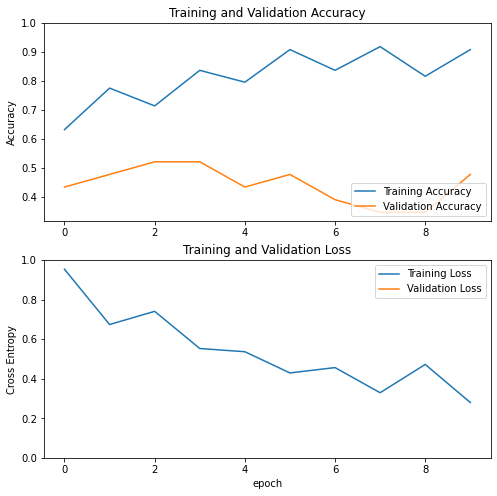

In [41]:
# Visualizing the Learning curves [OPTIONAL]
#
# Let's take a look at the learning curves of the training and validation accuracy/loss
# When using the MobileNet V2 base model as a fixed feature extractor.

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [39]:
model.metrics_names

['loss', 'acc']

In [42]:
"""## Fine tuning
In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.
One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.
### Un-freeze the top layers of the model
All you need to do is unfreeze the `base_model` and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.
"""

# Setting back to trainable
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [43]:
# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model
# Compile the model using a much lower training rate.
# Notice the parameter in Adam() function, parameter passed to Adam is the learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

# Getting the summary of the final model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 2,626,854
Trainable params: 2,231,462
Non-trainable params: 395,392
_________________________________________________________________


In [44]:
# Printing Training Variables
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


In [45]:
# Continue Train the model
history_fine = model.fit(train_generator,
                         epochs=5,
                         validation_data=val_generator
                         )
# Saving the Trained Model to the keras h5 format.
# So in future, if we want to convert again, we don't have to go through the whole process again
saved_model_dir = 'save/fine_tuning.h5'
model.save(saved_model_dir)
print("Model Saved to save/fine_tuning.h5")

Epoch 1/5
20/20 [==============================] - 44s 2s/step - loss: 0.1656 - acc: 0.9694 - val_loss: 3.7330 - val_acc: 0.4783
Epoch 2/5
20/20 [==============================] - 27s 1s/step - loss: 0.0930 - acc: 0.9796 - val_loss: 3.9417 - val_acc: 0.4783
Epoch 3/5
20/20 [==============================] - 27s 1s/step - loss: 0.2281 - acc: 0.9490 - val_loss: 3.3572 - val_acc: 0.4783
Epoch 4/5
20/20 [==============================] - 27s 1s/step - loss: 0.1066 - acc: 0.9694 - val_loss: 3.8537 - val_acc: 0.4783
Epoch 5/5
20/20 [==============================] - 27s 1s/step - loss: 0.1244 - acc: 0.9388 - val_loss: 3.2696 - val_acc: 0.4783
Model Saved to save/fine_tuning.h5
